# ITAEE

#### Libraries 

In [296]:
import sys
import os
import pandas as pd
import numpy as np
import time
import requests
from datetime import datetime
from dateutil.relativedelta import relativedelta


# For creating cool charts :)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
from matplotlib import image
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates

# We load pre-defined functions, fonts and stylesheet.
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\utils")
    sys.path.append(module_path+"\\assets")

from tukan_helper_functions import *

path = [x for x in sys.path if "utils" in x][0]

# Optional for TUKAN's mplstylesheet
plt.style.use(module_path + '\\utils\\tukan_style.mpl')

In [297]:
import geopandas as gpd

#### Loading map polygons

In [298]:
# Read maps

# df_mun = gpd.read_file("../../../assets/maps/00mun.shp")
df_edo = gpd.read_file("../../../assets/maps/00ent.shp")

#INEGI - TUKAN geography mapping

inegi_tukan_map = pd.read_csv('../../../assets/maps/inegi_geography_map.csv', dtype={'CVEGEO':'str'})

# And we apply the mapping to the shapefile

df_edo = pd.merge(df_edo, inegi_tukan_map[['CVEGEO', 'CVEGEO_tukan']], how = 'left', on = 'CVEGEO')
# df_edo = pd.merge(df_edo, inegi_tukan_map[['CVEGEO', 'CVEGEO_tukan']], how = 'left', on = 'CVEGEO')

#Rename columns
df_edo.rename(columns = {'CVEGEO_tukan':'geography__ref'}, inplace = True)
# df_edo.rename(columns = {'CVEGEO_tukan':'geography__ref'}, inplace = True)

###  1 . Quarterly growth for all economic activities, seasonal adjustment

#### Payload

In [299]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "adjustment_type",
        "economic_activity",
        "geography"
    ],
    "categories": {
        "adjustment_type": [
            "61060325ab095ed"
        ],
        "economic_activity": "all",
        "geography": "all"
    },
    "request": [
        {
            "table": "mex_inegi_itaee",
            "variables": [
                "92748be9624675d"
            ]
        }
    ],
    "from": "2020-01-27"
}

response = get_tukan_api_request(payload)
data = response["data"]
# data.head(3)

Success getting the data


#### Filtering data

In [300]:
data = data[(data["date"] == "2021-04-01") | (data["date"] == "2021-01-01")].reset_index(drop = True) # cambiar las fechas por nuevos trimestres
data['prev_qtr'] = data.groupby(['geography__ref'])['92748be9624675d'].shift()
data = data[data['date']== "2021-04-01"].reset_index(drop = True)
data['qtrly_var'] = (data['92748be9624675d']/data['prev_qtr'])-1
# data

#### Merging data and polygons

In [301]:
data = pd.merge(df_edo, data, how = "left", on = "geography__ref").reset_index(drop = True)

data.sort_values(by="qtrly_var", ascending = True).tail(3)

,CVEGEO,CVE_ENT,NOMGEO,geometry,geography__ref,date,adjustment_type__ref,adjustment_type,economic_activity__ref,economic_activity,geography,92748be9624675d,prev_qtr,qtrly_var
5,06,06,Colima,"MULTIPOLYGON (((1157633.318 768573.525, 115772...",1066aeadf0e6b1d,2021-04-01,61060325ab095ed,Ajuste estacional,dfeefc621d16d0c,Actividad económica,Colima,123.678142,113.425048,0.090395
17,18,18,Nayarit,"MULTIPOLYGON (((2161261.691 1008297.886, 21612...",d3d2e9958774cf3,2021-04-01,61060325ab095ed,Ajuste estacional,dfeefc621d16d0c,Actividad económica,Nayarit,143.391676,109.086208,0.314480
11,12,12,Guerrero,"MULTIPOLYGON (((2723457.629 539108.729, 272355...",71ecab7f1483f68,2021-04-01,61060325ab095ed,Ajuste estacional,dfeefc621d16d0c,Actividad económica,Guerrero,135.129671,102.785224,0.314680


#### Plot

d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


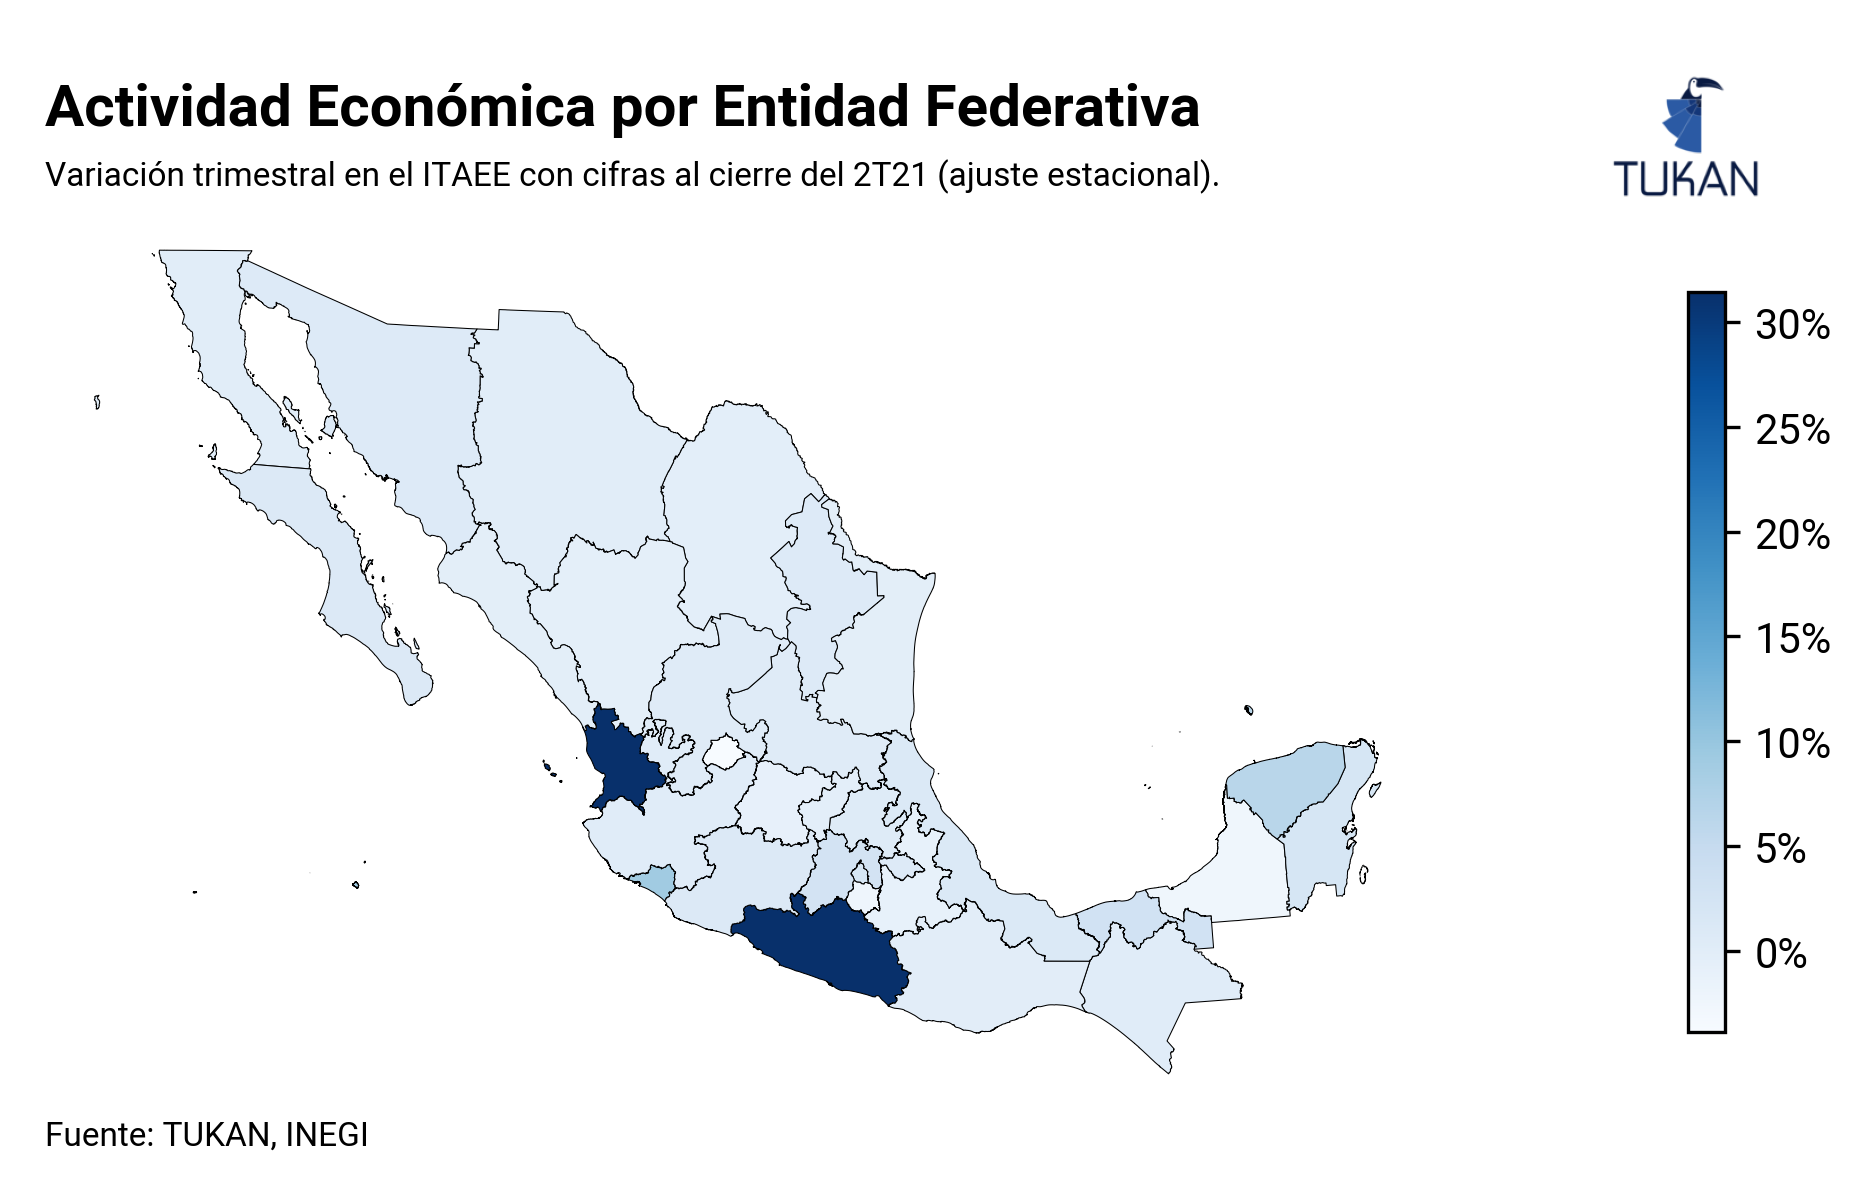

In [302]:
fig = plt.figure(figsize=(8, 4), dpi = 300)
gspec = mpl.gridspec.GridSpec(
    ncols=2, nrows=1, figure=fig, width_ratios = [.95,.05] #colorbar 05
)

ax1 = plt.subplot(gspec[0,0])
ax2 = plt.subplot(gspec[0,1])


gspec.update(wspace=-0.25, hspace=0, left = 0)
ax1.axes.set_axis_off()
ax2.axes.set_axis_off()


data.plot("qtrly_var", ax = ax1, cmap = "Blues", linewidths = 0.25, edgecolor = "black")

# # --- Dummy heatmap colorbar
a = np.expand_dims(data['qtrly_var'], axis=0)
heatmap=ax2.imshow(a, cmap = "Blues")
heatmap.set_visible(False)

fig.colorbar(heatmap, fraction=0.3, pad=-1, format = ticker.StrMethodFormatter('{x:.0%}'), ax = ax2)

fig.text(
    0.2,
    .95,
    "Actividad Económica por Entidad Federativa",
    size=14,
    weight = "bold"
)

fig.text(
    0.2,
    0.9,
    "Variación trimestral en el ITAEE con cifras al cierre del 2T21 (ajuste estacional).", #cambiar 2T21 por 3T21
    size=8
)

# Save plot with TUKAN logo, transparent and white.

fig.text(0.2, 0.1, "Fuente: TUKAN, INEGI", fontsize=8)

plt.tight_layout()


tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.78, .85, 0.15, 0.18], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/quarterly_growth_all_map.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

###  2 . Quarterly growth for commercial activities

#### Payload

In [303]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "adjustment_type",
        "economic_activity",
        "geography"
    ],
    "categories": {
        "adjustment_type": "all",
        "economic_activity": [
            "1d0185629b65ee3"
        ],
        "geography": "all"
    },
    "request": [
        {
            "table": "mex_inegi_itaee",
            "variables": [
                "92748be9624675d"
            ]
        }
    ],
    "from": "2020-01-27"
}

response = get_tukan_api_request(payload)
data = response["data"]
# data

Success getting the data


#### Filtering data

In [304]:
data = data[(data["date"] == "2021-04-01") | (data["date"] == "2021-01-01")].reset_index(drop = True) # cambiar las fechas por nuevos trimestres
data['prev_qtr'] = data.groupby(['geography__ref'])['92748be9624675d'].shift()
data = data[data['date']== "2021-04-01"].reset_index(drop = True)
data['qtrly_var'] = (data['92748be9624675d']/data['prev_qtr'])-1
# data

#### Merging data and polygons

In [305]:
data = pd.merge(df_edo, data, how = "left", on = "geography__ref").reset_index(drop = True)

data.sort_values(by="qtrly_var", ascending = True).tail(3)

,CVEGEO,CVE_ENT,NOMGEO,geometry,geography__ref,date,economic_activity__ref,economic_activity,adjustment_type__ref,adjustment_type,geography,92748be9624675d,prev_qtr,qtrly_var
7,08,08,Chihuahua,"POLYGON ((1961978.327 2201082.365, 1961978.967...",df4199cdf95d9a2,2021-04-01,1d0185629b65ee3,Comercio,a7e5d5a7d084363,Original,Chihuahua,126.074004,112.876468,0.116920
25,26,26,Sonora,"MULTIPOLYGON (((1621359.972 1783423.440, 16213...",503feee7604f872,2021-04-01,1d0185629b65ee3,Comercio,a7e5d5a7d084363,Original,Sonora,116.830853,104.065942,0.122662
8,09,09,Ciudad de México,"POLYGON ((2802175.660 843326.718, 2801806.564 ...",a3610ba4cc376e9,2021-04-01,1d0185629b65ee3,Comercio,a7e5d5a7d084363,Original,Ciudad de México,98.479339,87.341938,0.127515


#### Plot

d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


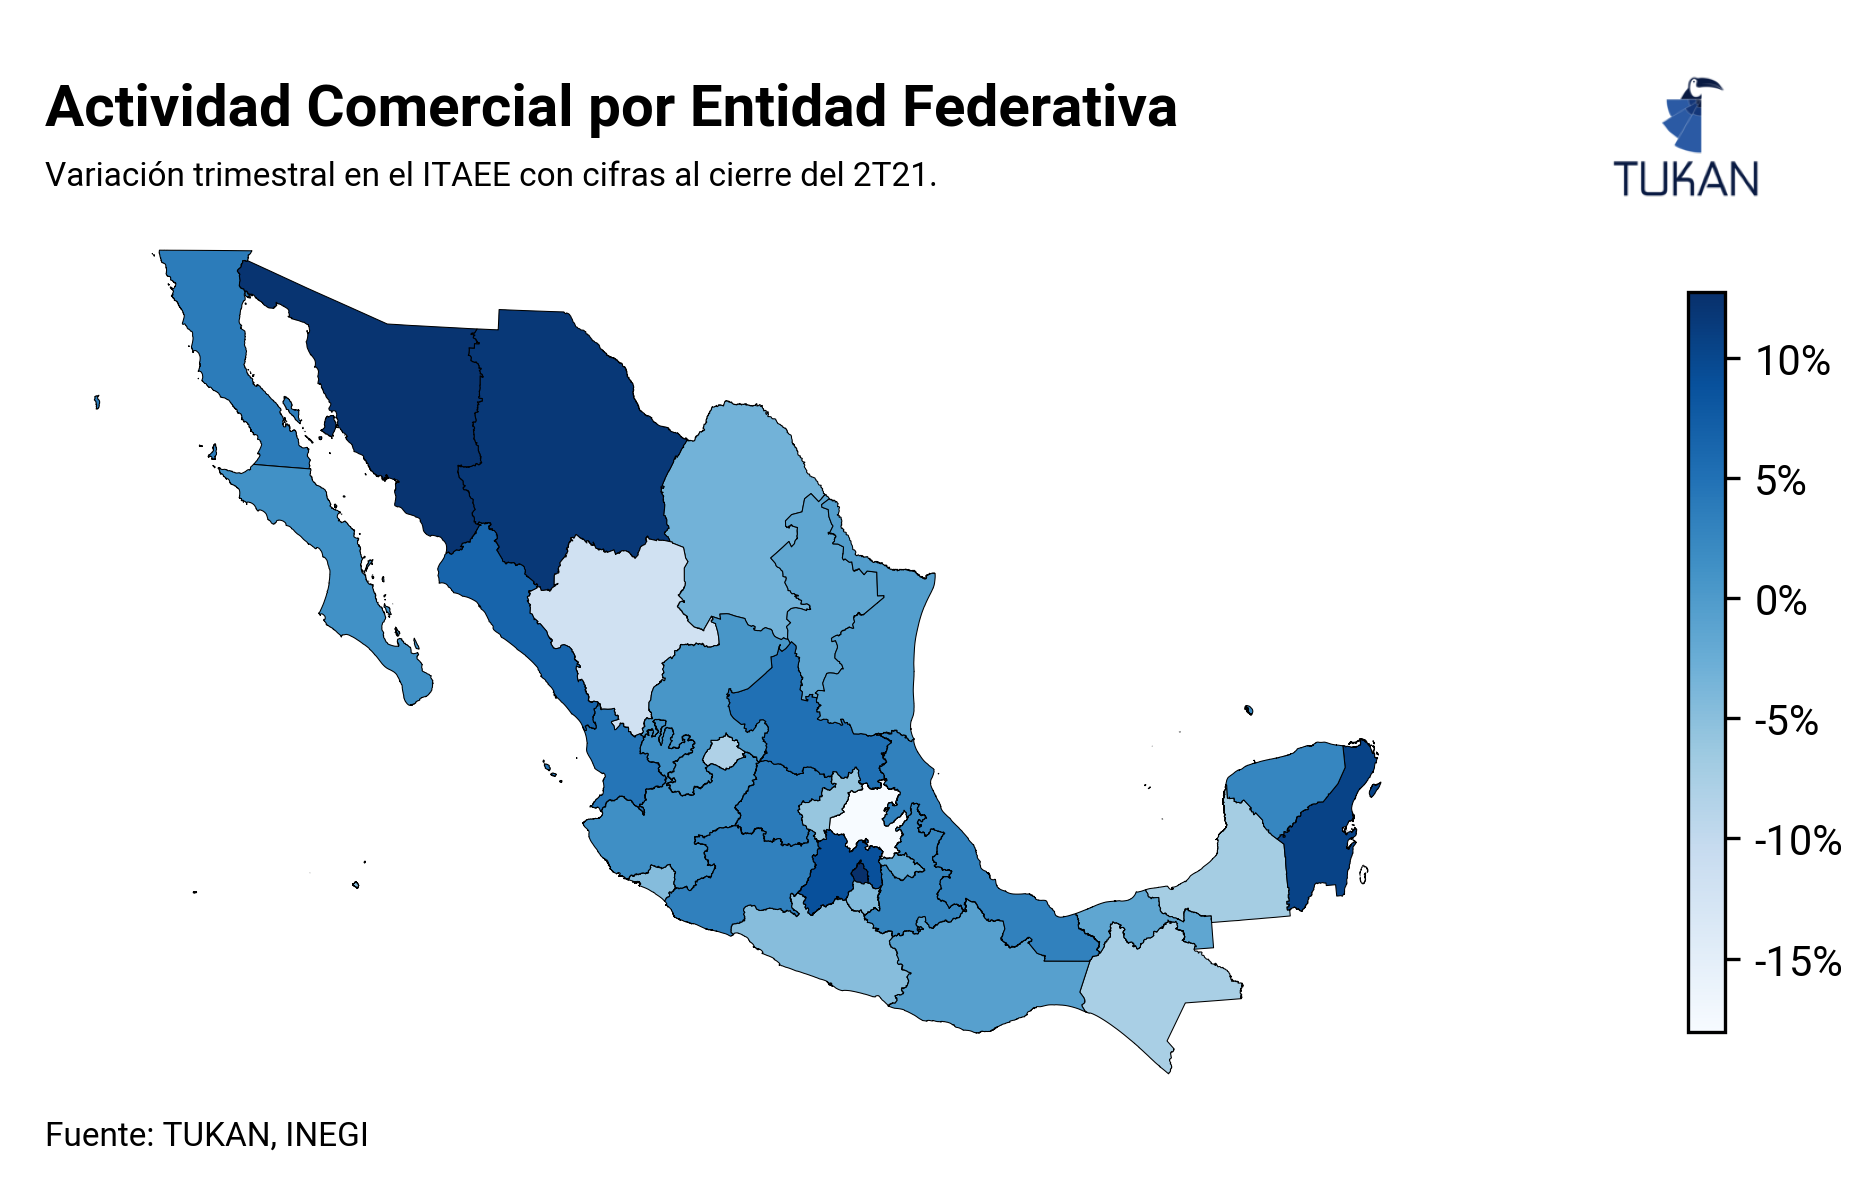

In [306]:
fig = plt.figure(figsize=(8, 4), dpi = 300)
gspec = mpl.gridspec.GridSpec(
    ncols=2, nrows=1, figure=fig, width_ratios = [.95,.05] #colorbar 05
)

ax1 = plt.subplot(gspec[0,0])
ax2 = plt.subplot(gspec[0,1])


gspec.update(wspace=-0.25, hspace=0, left = 0)
ax1.axes.set_axis_off()
ax2.axes.set_axis_off()


data.plot("qtrly_var", ax = ax1, cmap = "Blues", linewidths = 0.25, edgecolor = "black")

# # --- Dummy heatmap colorbar
a = np.expand_dims(data['qtrly_var'], axis=0)
heatmap=ax2.imshow(a, cmap = "Blues")
heatmap.set_visible(False)

fig.colorbar(heatmap, fraction=0.3, pad=-1, format = ticker.StrMethodFormatter('{x:.0%}'), ax = ax2)

fig.text(
    0.2,
    .95,
    "Actividad Comercial por Entidad Federativa",
    size=14,
    weight = "bold"
)

fig.text(
    0.2,
    0.9,
    "Variación trimestral en el ITAEE con cifras al cierre del 2T21.", #cambiar 2T21 por 3T21
    size=8
)

# Save plot with TUKAN logo, transparent and white.

fig.text(0.2, 0.1, "Fuente: TUKAN, INEGI", fontsize=8)

plt.tight_layout()


tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.78, .85, 0.15, 0.18], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/quarterly_growth_commerce_map.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

###  3 . Quarterly growth for manufacturing activities

#### Payload

In [307]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        "adjustment_type",
        "economic_activity",
        "geography"
    ],
    "categories": {
        "adjustment_type": "all",
        "economic_activity": [
            "faa2a8d0af8a72c"
        ],
        "geography": "all"
    },
    "request": [
        {
            "table": "mex_inegi_itaee",
            "variables": [
                "92748be9624675d"
            ]
        }
    ],
    "from": "2020-01-27"
}

response = get_tukan_api_request(payload)
data = response["data"]
# data

Success getting the data


#### Filtering data

In [308]:
data = data[(data["date"] == "2021-04-01") | (data["date"] == "2021-01-01")].reset_index(drop = True) # cambiar las fechas por nuevos trimestres
data['prev_qtr'] = data.groupby(['geography__ref'])['92748be9624675d'].shift()
data = data[data['date']== "2021-04-01"].reset_index(drop = True)
data['qtrly_var'] = (data['92748be9624675d']/data['prev_qtr'])-1
# data

#### Merging data and polygons

In [309]:
data = pd.merge(df_edo, data, how = "left", on = "geography__ref").reset_index(drop = True)

data.sort_values(by="qtrly_var", ascending = True).tail(3)

,CVEGEO,CVE_ENT,NOMGEO,geometry,geography__ref,date,economic_activity__ref,economic_activity,adjustment_type__ref,adjustment_type,geography,92748be9624675d,prev_qtr,qtrly_var
14,15,15,México,"POLYGON ((2717218.900 921748.845, 2717277.833 ...",35f06e5ac6c66c6,2021-04-01,faa2a8d0af8a72c,Industrias manufactureras,a7e5d5a7d084363,Original,Estado de México,96.724688,89.062697,0.086029
22,23,23,Quintana Roo,"MULTIPOLYGON (((4039086.131 787620.709, 403895...",ff9e50f58bb1ce3,2021-04-01,faa2a8d0af8a72c,Industrias manufactureras,a7e5d5a7d084363,Original,Quintana Roo,158.571854,141.931845,0.117239
11,12,12,Guerrero,"MULTIPOLYGON (((2723457.629 539108.729, 272355...",71ecab7f1483f68,2021-04-01,faa2a8d0af8a72c,Industrias manufactureras,a7e5d5a7d084363,Original,Guerrero,96.163154,83.429858,0.152623


#### Plot

d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


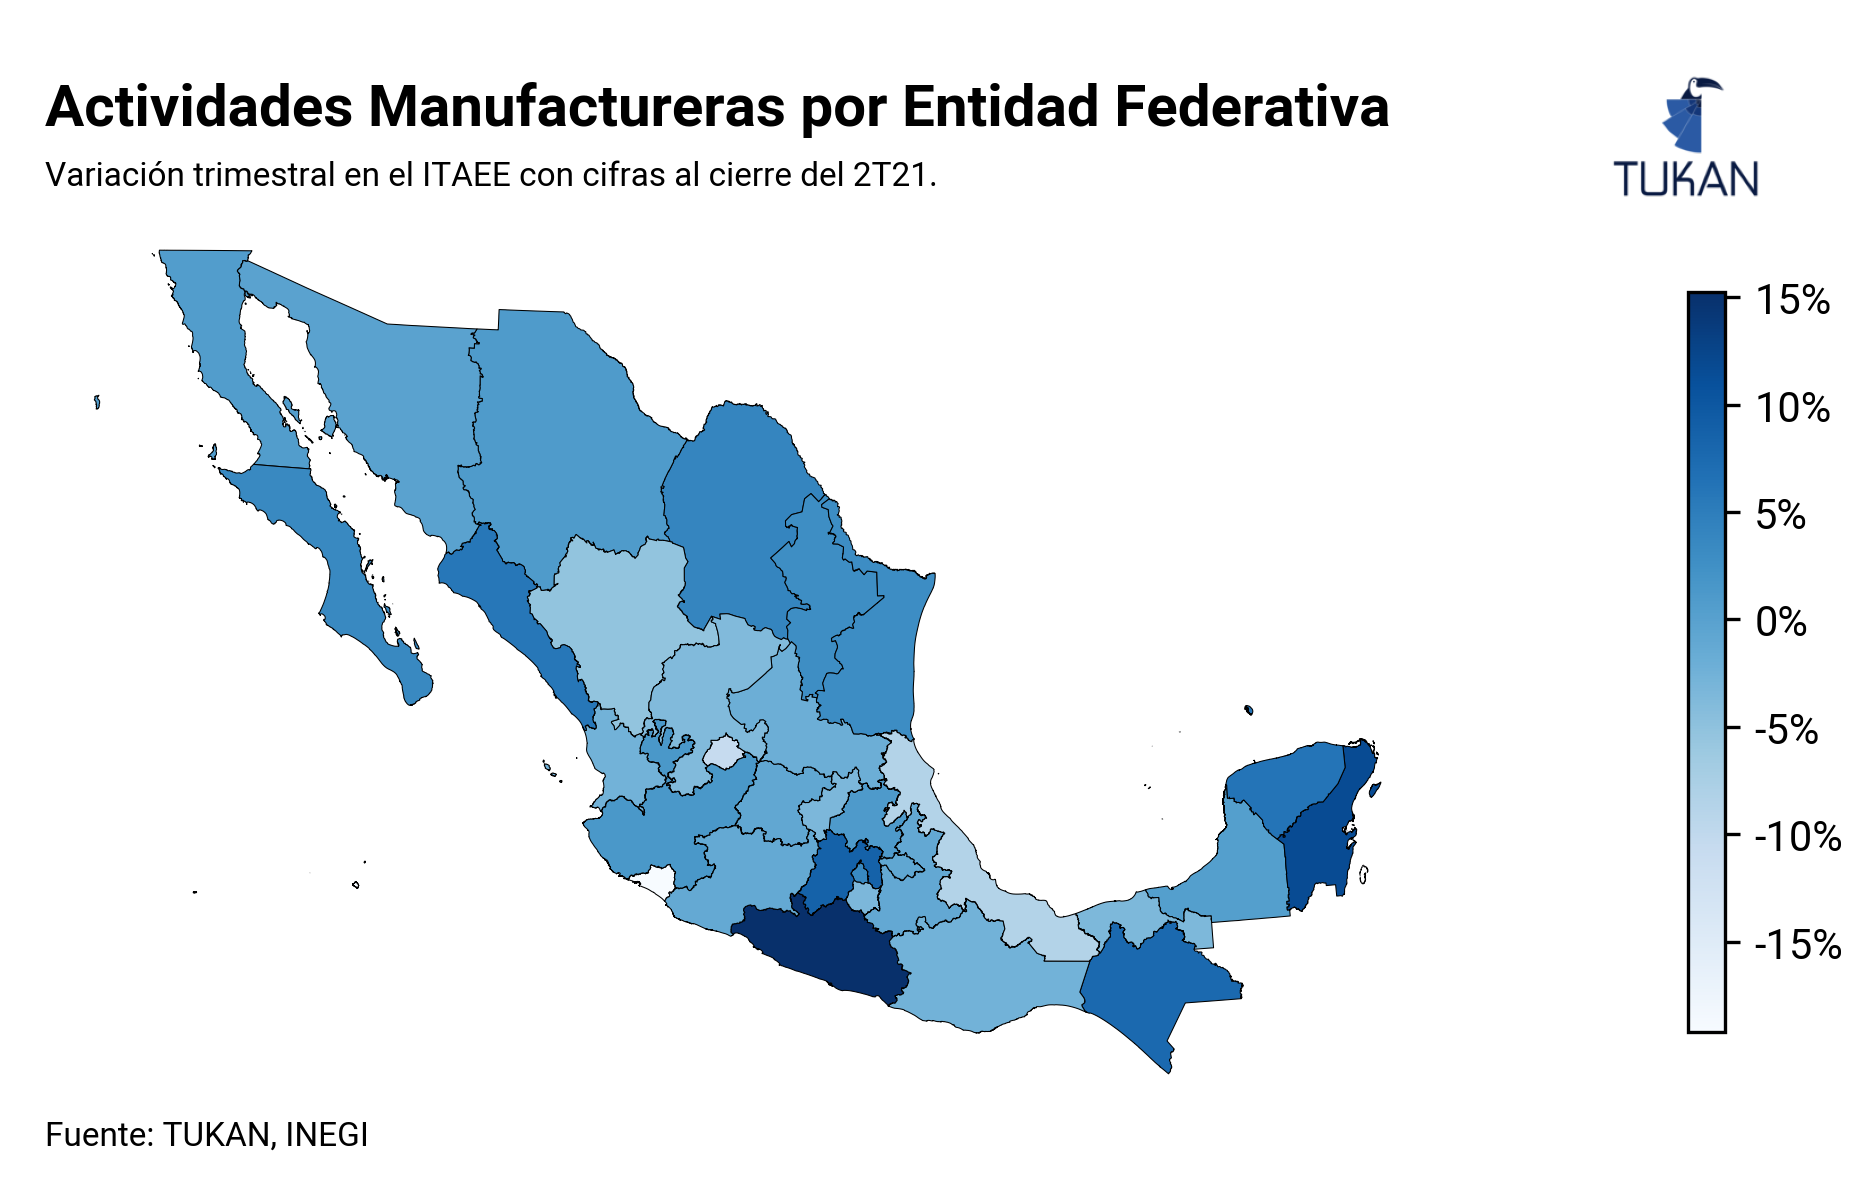

In [310]:
fig = plt.figure(figsize=(8, 4), dpi = 300)
gspec = mpl.gridspec.GridSpec(
    ncols=2, nrows=1, figure=fig, width_ratios = [.95,.05] #colorbar 05
)

ax1 = plt.subplot(gspec[0,0])
ax2 = plt.subplot(gspec[0,1])


gspec.update(wspace=-0.25, hspace=0, left = 0)
ax1.axes.set_axis_off()
ax2.axes.set_axis_off()


data.plot("qtrly_var", ax = ax1, cmap = "Blues", linewidths = 0.25, edgecolor = "black")

# # --- Dummy heatmap colorbar
a = np.expand_dims(data['qtrly_var'], axis=0)
heatmap=ax2.imshow(a, cmap = "Blues")
heatmap.set_visible(False)

fig.colorbar(heatmap, fraction=0.3, pad=-1, format = ticker.StrMethodFormatter('{x:.0%}'), ax = ax2)

fig.text(
    0.2,
    .95,
    "Actividades Manufactureras por Entidad Federativa",
    size=14,
    weight = "bold"
)

fig.text(
    0.2,
    0.9,
    "Variación trimestral en el ITAEE con cifras al cierre del 2T21.", #cambiar 2T21 por 3T21
    size=8
)

# Save plot with TUKAN logo, transparent and white.

fig.text(0.2, 0.1, "Fuente: TUKAN, INEGI", fontsize=8)

plt.tight_layout()


tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.78, .85, 0.15, 0.18], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/quarterly_growth_manufacturing_map.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

###  4 . Yearly growth for commercial activities

#### Payload

In [311]:
payload = {
    "type": "data_table",
    "operation": "yoy_growth_rel",
    "language": "es",
    "group_by": [
        "adjustment_type",
        "economic_activity",
        "geography"
    ],
    "categories": {
        "adjustment_type": "all",
        "economic_activity": [
            "1d0185629b65ee3"
        ],
        "geography": "all"
    },
    "request": [
        {
            "table": "mex_inegi_itaee",
            "variables": [
                "92748be9624675d"
            ]
        }
    ]
}

response = get_tukan_api_request(payload)
data = response["data"]
# data

Success getting the data


#### Filtering data

In [312]:
# data is ready to go
data['date'].unique()

array(['2021-04-01T00:00:00.000000000'], dtype='datetime64[ns]')

#### Merging data and polygons

In [313]:
data = pd.merge(df_edo, data, how = "left", on = "geography__ref").reset_index(drop = True)

data.sort_values(by="92748be9624675d", ascending = True).tail(3)

,CVEGEO,CVE_ENT,NOMGEO,geometry,geography__ref,date,economic_activity__ref,economic_activity,adjustment_type__ref,adjustment_type,geography,92748be9624675d
2,03,03,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",360a302c378e710,2021-04-01,1d0185629b65ee3,Comercio,a7e5d5a7d084363,Original,Baja California Sur,0.466109
28,29,29,Tlaxcala,"POLYGON ((2912153.554 863641.586, 2912195.798 ...",5ec6f2e8362d8b2,2021-04-01,1d0185629b65ee3,Comercio,a7e5d5a7d084363,Original,Tlaxcala,0.479547
22,23,23,Quintana Roo,"MULTIPOLYGON (((4039086.131 787620.709, 403895...",ff9e50f58bb1ce3,2021-04-01,1d0185629b65ee3,Comercio,a7e5d5a7d084363,Original,Quintana Roo,0.653968


#### Plot

d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


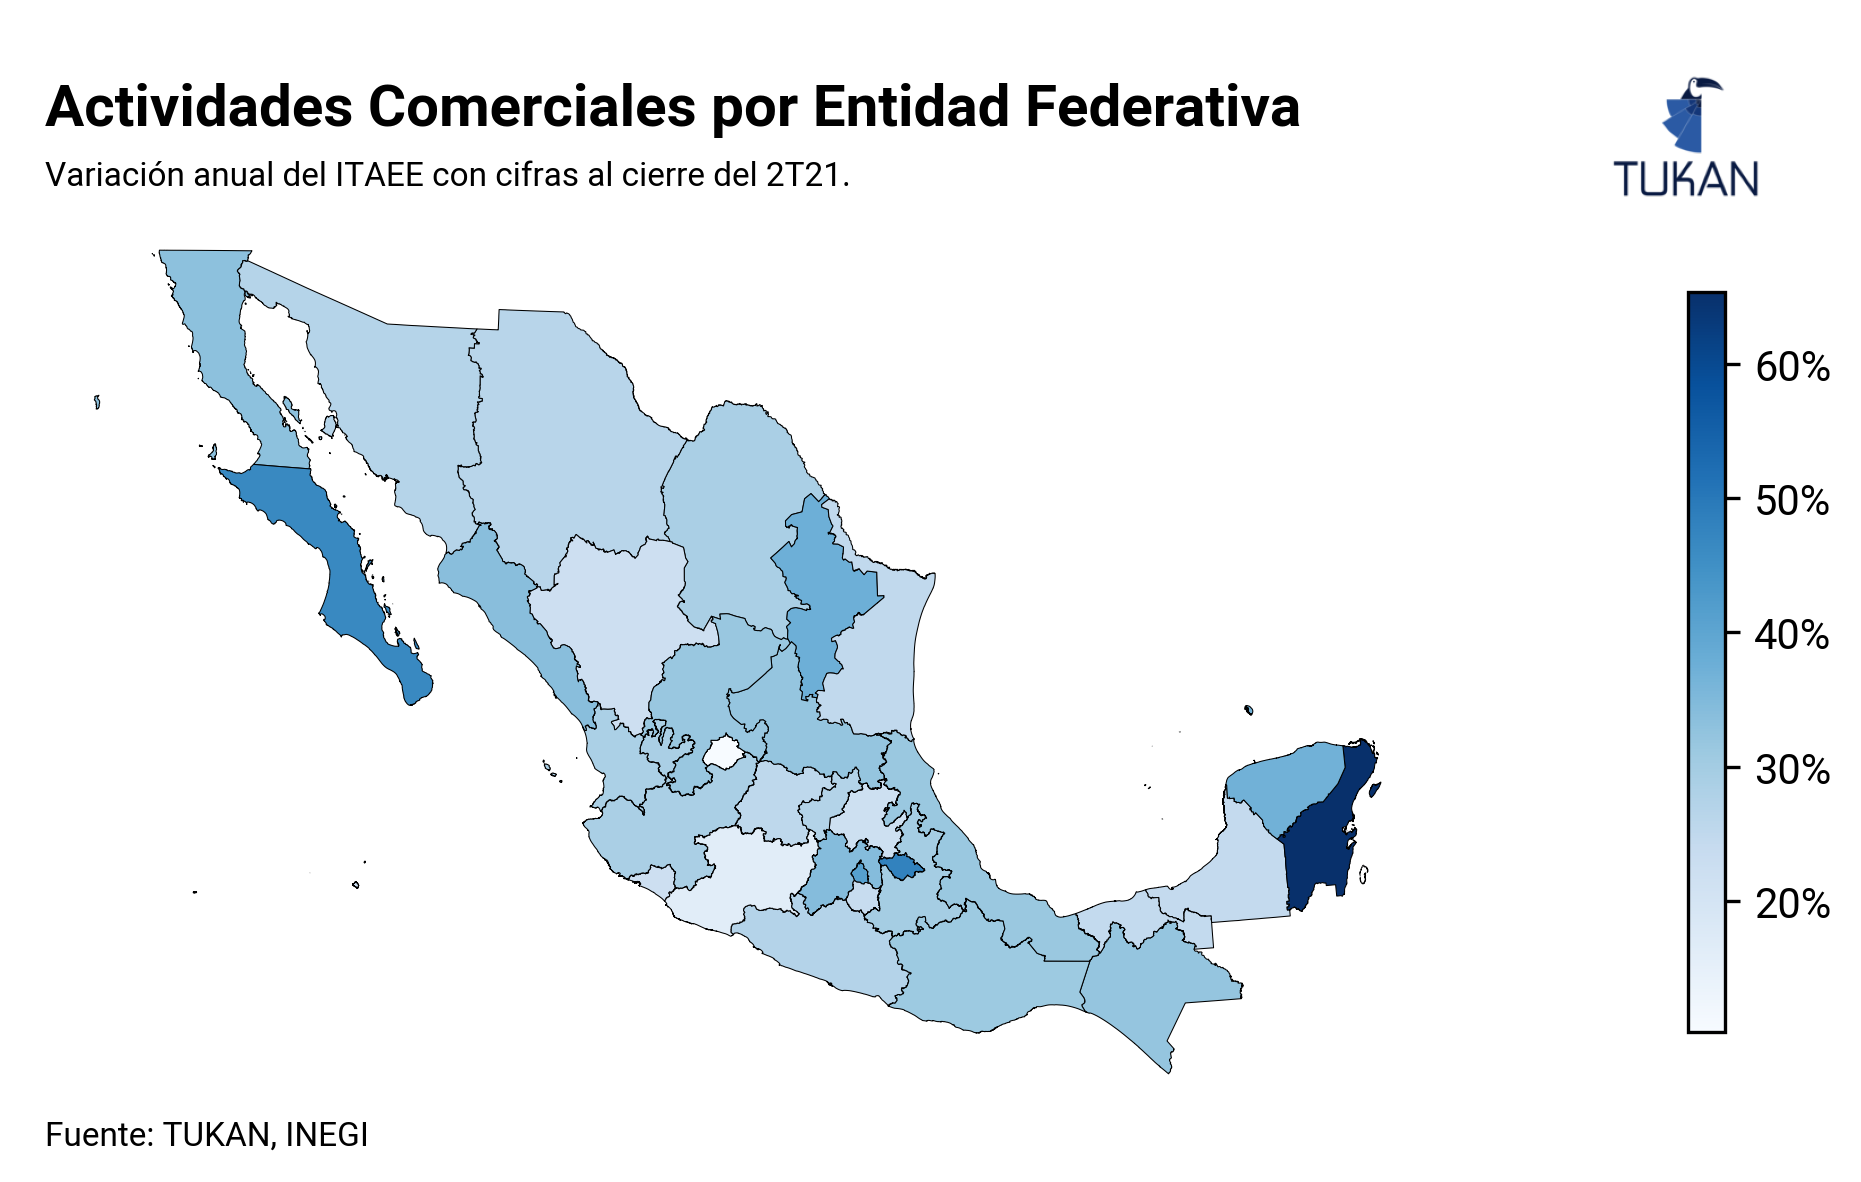

In [314]:
fig = plt.figure(figsize=(8, 4), dpi = 300)
gspec = mpl.gridspec.GridSpec(
    ncols=2, nrows=1, figure=fig, width_ratios = [.95,.05] #colorbar 05
)

ax1 = plt.subplot(gspec[0,0])
ax2 = plt.subplot(gspec[0,1])


gspec.update(wspace=-0.25, hspace=0, left = 0)
ax1.axes.set_axis_off()
ax2.axes.set_axis_off()


data.plot("92748be9624675d", ax = ax1, cmap = "Blues", linewidths = 0.25, edgecolor = "black")

# # --- Dummy heatmap colorbar
a = np.expand_dims(data['92748be9624675d'], axis=0)
heatmap=ax2.imshow(a, cmap = "Blues")
heatmap.set_visible(False)

fig.colorbar(heatmap, fraction=0.3, pad=-1, format = ticker.StrMethodFormatter('{x:.0%}'), ax = ax2)

fig.text(
    0.2,
    .95,
    "Actividades Comerciales por Entidad Federativa",
    size=14,
    weight = "bold"
)

fig.text(
    0.2,
    0.9,
    "Variación anual del ITAEE con cifras al cierre del 2T21.", #cambiar 2T21 por 3T21
    size=8
)

# Save plot with TUKAN logo, transparent and white.

fig.text(0.2, 0.1, "Fuente: TUKAN, INEGI", fontsize=8)

plt.tight_layout()


tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.78, .85, 0.15, 0.18], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/yearly_growth_commerce_map.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

###  5 . Yearly growth for manufacturing activities

#### Payload

In [315]:
payload = {
    "type": "data_table",
    "operation": "yoy_growth_rel",
    "language": "es",
    "group_by": [
        "adjustment_type",
        "economic_activity",
        "geography"
    ],
    "categories": {
        "adjustment_type": "all",
        "economic_activity": [
            "faa2a8d0af8a72c"
        ],
        "geography": "all"
    },
    "request": [
        {
            "table": "mex_inegi_itaee",
            "variables": [
                "92748be9624675d"
            ]
        }
    ]
}

response = get_tukan_api_request(payload)
data = response["data"]
# data

Success getting the data


#### Filtering data

In [316]:
# data is ready to go
data['date'].unique()

array(['2021-04-01T00:00:00.000000000'], dtype='datetime64[ns]')

#### Merging data and polygons

In [317]:
data = pd.merge(df_edo, data, how = "left", on = "geography__ref").reset_index(drop = True)

data.sort_values(by="92748be9624675d", ascending = True).tail(3)

,CVEGEO,CVE_ENT,NOMGEO,geometry,geography__ref,date,economic_activity__ref,economic_activity,adjustment_type__ref,adjustment_type,geography,92748be9624675d
4,05,05,Coahuila de Zaragoza,"POLYGON ((2469954.193 1978522.993, 2469982.807...",18586f4a5105126,2021-04-01,faa2a8d0af8a72c,Industrias manufactureras,a7e5d5a7d084363,Original,Coahuila de Zaragoza,0.557472
0,01,01,Aguascalientes,"POLYGON ((2470517.824 1155028.588, 2470552.248...",a11e95a3853fb69,2021-04-01,faa2a8d0af8a72c,Industrias manufactureras,a7e5d5a7d084363,Original,Aguascalientes,0.742111
20,21,21,Puebla,"POLYGON ((2930806.280 987523.589, 2930857.791 ...",bd8b4a37deee845,2021-04-01,faa2a8d0af8a72c,Industrias manufactureras,a7e5d5a7d084363,Original,Puebla,1.073755


#### Plot

d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


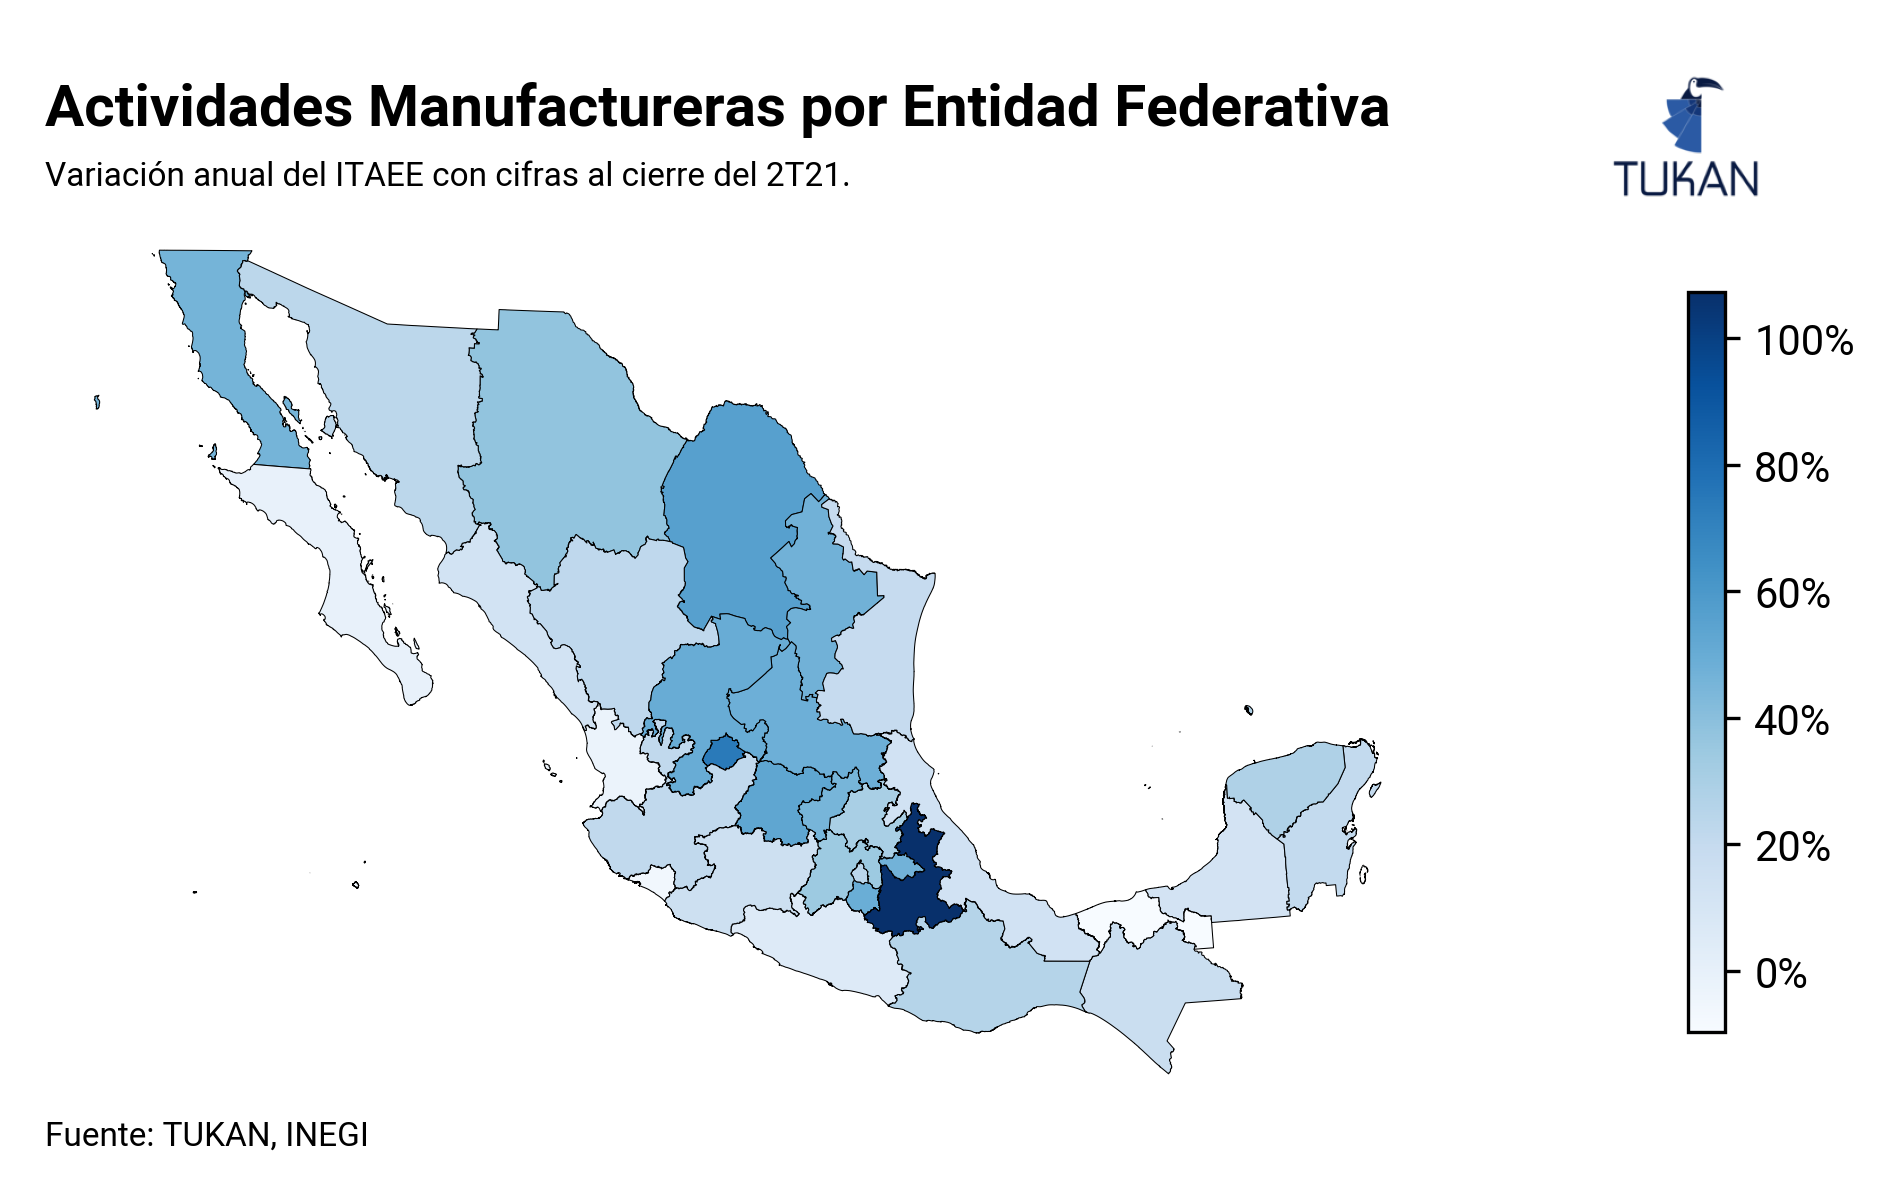

In [318]:
fig = plt.figure(figsize=(8, 4), dpi = 300)
gspec = mpl.gridspec.GridSpec(
    ncols=2, nrows=1, figure=fig, width_ratios = [.95,.05] #colorbar 05
)

ax1 = plt.subplot(gspec[0,0])
ax2 = plt.subplot(gspec[0,1])


gspec.update(wspace=-0.25, hspace=0, left = 0)
ax1.axes.set_axis_off()
ax2.axes.set_axis_off()


data.plot("92748be9624675d", ax = ax1, cmap = "Blues", linewidths = 0.25, edgecolor = "black")

# # --- Dummy heatmap colorbar
a = np.expand_dims(data['92748be9624675d'], axis=0)
heatmap=ax2.imshow(a, cmap = "Blues")
heatmap.set_visible(False)

fig.colorbar(heatmap, fraction=0.3, pad=-1, format = ticker.StrMethodFormatter('{x:.0%}'), ax = ax2)

fig.text(
    0.2,
    .95,
    "Actividades Manufactureras por Entidad Federativa",
    size=14,
    weight = "bold"
)

fig.text(
    0.2,
    0.9,
    "Variación anual del ITAEE con cifras al cierre del 2T21.", #cambiar 2T21 por 3T21
    size=8
)

# Save plot with TUKAN logo, transparent and white.

fig.text(0.2, 0.1, "Fuente: TUKAN, INEGI", fontsize=8)

plt.tight_layout()


tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.78, .85, 0.15, 0.18], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/yearly_growth_manufacturing_map.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

###  6 . Yearly growth for primary activities

#### Payload

In [319]:
payload = {
    "type": "data_table",
    "operation": "yoy_growth_rel",
    "language": "es",
    "group_by": [
        "adjustment_type",
        "economic_activity",
        "geography"
    ],
    "categories": {
        "adjustment_type": "all",
        "economic_activity": [
            "7460634ca523beb"
        ],
        "geography": "all"
    },
    "request": [
        {
            "table": "mex_inegi_itaee",
            "variables": [
                "92748be9624675d"
            ]
        }
    ]
}

response = get_tukan_api_request(payload)
data = response["data"]
# data

Success getting the data


#### Filtering data

In [320]:
# data is ready to go
data['date'].unique()

array(['2021-04-01T00:00:00.000000000'], dtype='datetime64[ns]')

#### Merging data and polygons

In [321]:
data = pd.merge(df_edo, data, how = "left", on = "geography__ref").reset_index(drop = True)

data.sort_values(by="92748be9624675d", ascending = True).tail(3)

,CVEGEO,CVE_ENT,NOMGEO,geometry,geography__ref,date,economic_activity__ref,economic_activity,adjustment_type__ref,adjustment_type,geography,92748be9624675d
23,24,24,San Luis Potosí,"POLYGON ((2640890.453 1374316.087, 2641215.593...",468bc66c95ecfe6,2021-04-01,7460634ca523beb,Actividades primarias,a7e5d5a7d084363,Original,San Luis Potosí,0.232782
15,16,16,Michoacán de Ocampo,"POLYGON ((2498953.539 930779.820, 2498903.253 ...",c51b7a801a43fde,2021-04-01,7460634ca523beb,Actividades primarias,a7e5d5a7d084363,Original,Michoacán de Ocampo,0.266391
22,23,23,Quintana Roo,"MULTIPOLYGON (((4039086.131 787620.709, 403895...",ff9e50f58bb1ce3,2021-04-01,7460634ca523beb,Actividades primarias,a7e5d5a7d084363,Original,Quintana Roo,0.275800


#### Plot

d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


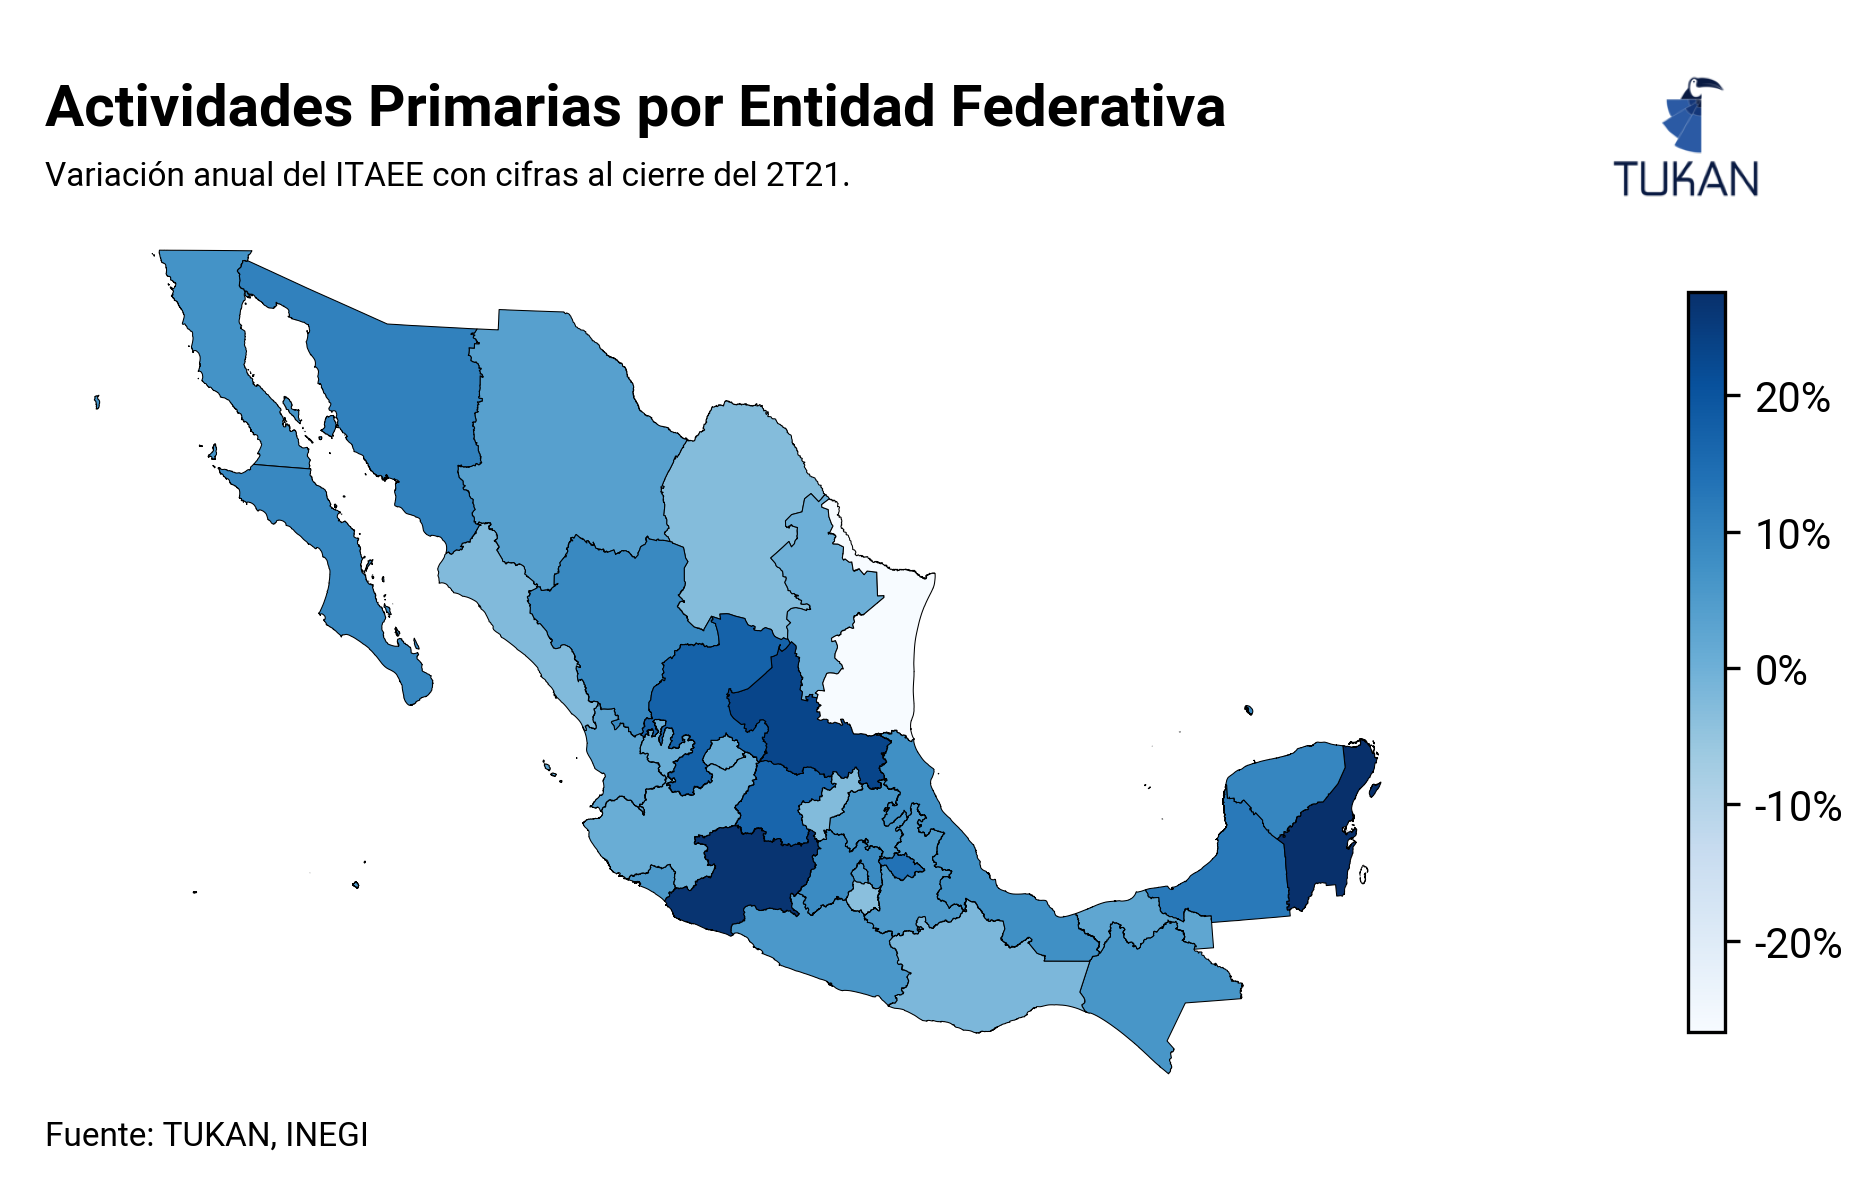

In [322]:
fig = plt.figure(figsize=(8, 4), dpi = 300)
gspec = mpl.gridspec.GridSpec(
    ncols=2, nrows=1, figure=fig, width_ratios = [.95,.05] #colorbar 05
)

ax1 = plt.subplot(gspec[0,0])
ax2 = plt.subplot(gspec[0,1])


gspec.update(wspace=-0.25, hspace=0, left = 0)
ax1.axes.set_axis_off()
ax2.axes.set_axis_off()


data.plot("92748be9624675d", ax = ax1, cmap = "Blues", linewidths = 0.25, edgecolor = "black")

# # --- Dummy heatmap colorbar
a = np.expand_dims(data['92748be9624675d'], axis=0)
heatmap=ax2.imshow(a, cmap = "Blues")
heatmap.set_visible(False)

fig.colorbar(heatmap, fraction=0.3, pad=-1, format = ticker.StrMethodFormatter('{x:.0%}'), ax = ax2)

fig.text(
    0.2,
    .95,
    "Actividades Primarias por Entidad Federativa",
    size=14,
    weight = "bold"
)

fig.text(
    0.2,
    0.9,
    "Variación anual del ITAEE con cifras al cierre del 2T21.", #cambiar 2T21 por 3T21
    size=8
)

# Save plot with TUKAN logo, transparent and white.

fig.text(0.2, 0.1, "Fuente: TUKAN, INEGI", fontsize=8)

plt.tight_layout()


tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.78, .85, 0.15, 0.18], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/yearly_growth_primary_map.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

###  7 . Yearly growth for secondary activities

#### Payload

In [323]:
payload = {
    "type": "data_table",
    "operation": "yoy_growth_rel",
    "language": "es",
    "group_by": [
        "adjustment_type",
        "economic_activity",
        "geography"
    ],
    "categories": {
        "adjustment_type": "all",
        "economic_activity": [
            "761bc00426e1c48"
        ],
        "geography": "all"
    },
    "request": [
        {
            "table": "mex_inegi_itaee",
            "variables": [
                "92748be9624675d"
            ]
        }
    ]
}

response = get_tukan_api_request(payload)
data = response["data"]
# data

Success getting the data


#### Filtering data

In [324]:
# data is ready to go
data['date'].unique()

array(['2021-04-01T00:00:00.000000000'], dtype='datetime64[ns]')

#### Merging data and polygons

In [325]:
data = pd.merge(df_edo, data, how = "left", on = "geography__ref").reset_index(drop = True)

data.sort_values(by="92748be9624675d", ascending = True).tail(3)

,CVEGEO,CVE_ENT,NOMGEO,geometry,geography__ref,date,economic_activity__ref,economic_activity,adjustment_type__ref,adjustment_type,geography,92748be9624675d
31,32,32,Zacatecas,"POLYGON ((2515182.307 1441549.749, 2515937.734...",737125369fa1d94,2021-04-01,761bc00426e1c48,Actividades secundarias,a7e5d5a7d084363,Original,Zacatecas,0.517744
19,20,20,Oaxaca,"MULTIPOLYGON (((3120848.310 424036.022, 312086...",16600f577a6aa5d,2021-04-01,761bc00426e1c48,Actividades secundarias,a7e5d5a7d084363,Original,Oaxaca,0.542706
20,21,21,Puebla,"POLYGON ((2930806.280 987523.589, 2930857.791 ...",bd8b4a37deee845,2021-04-01,761bc00426e1c48,Actividades secundarias,a7e5d5a7d084363,Original,Puebla,0.834982


#### Plot

d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


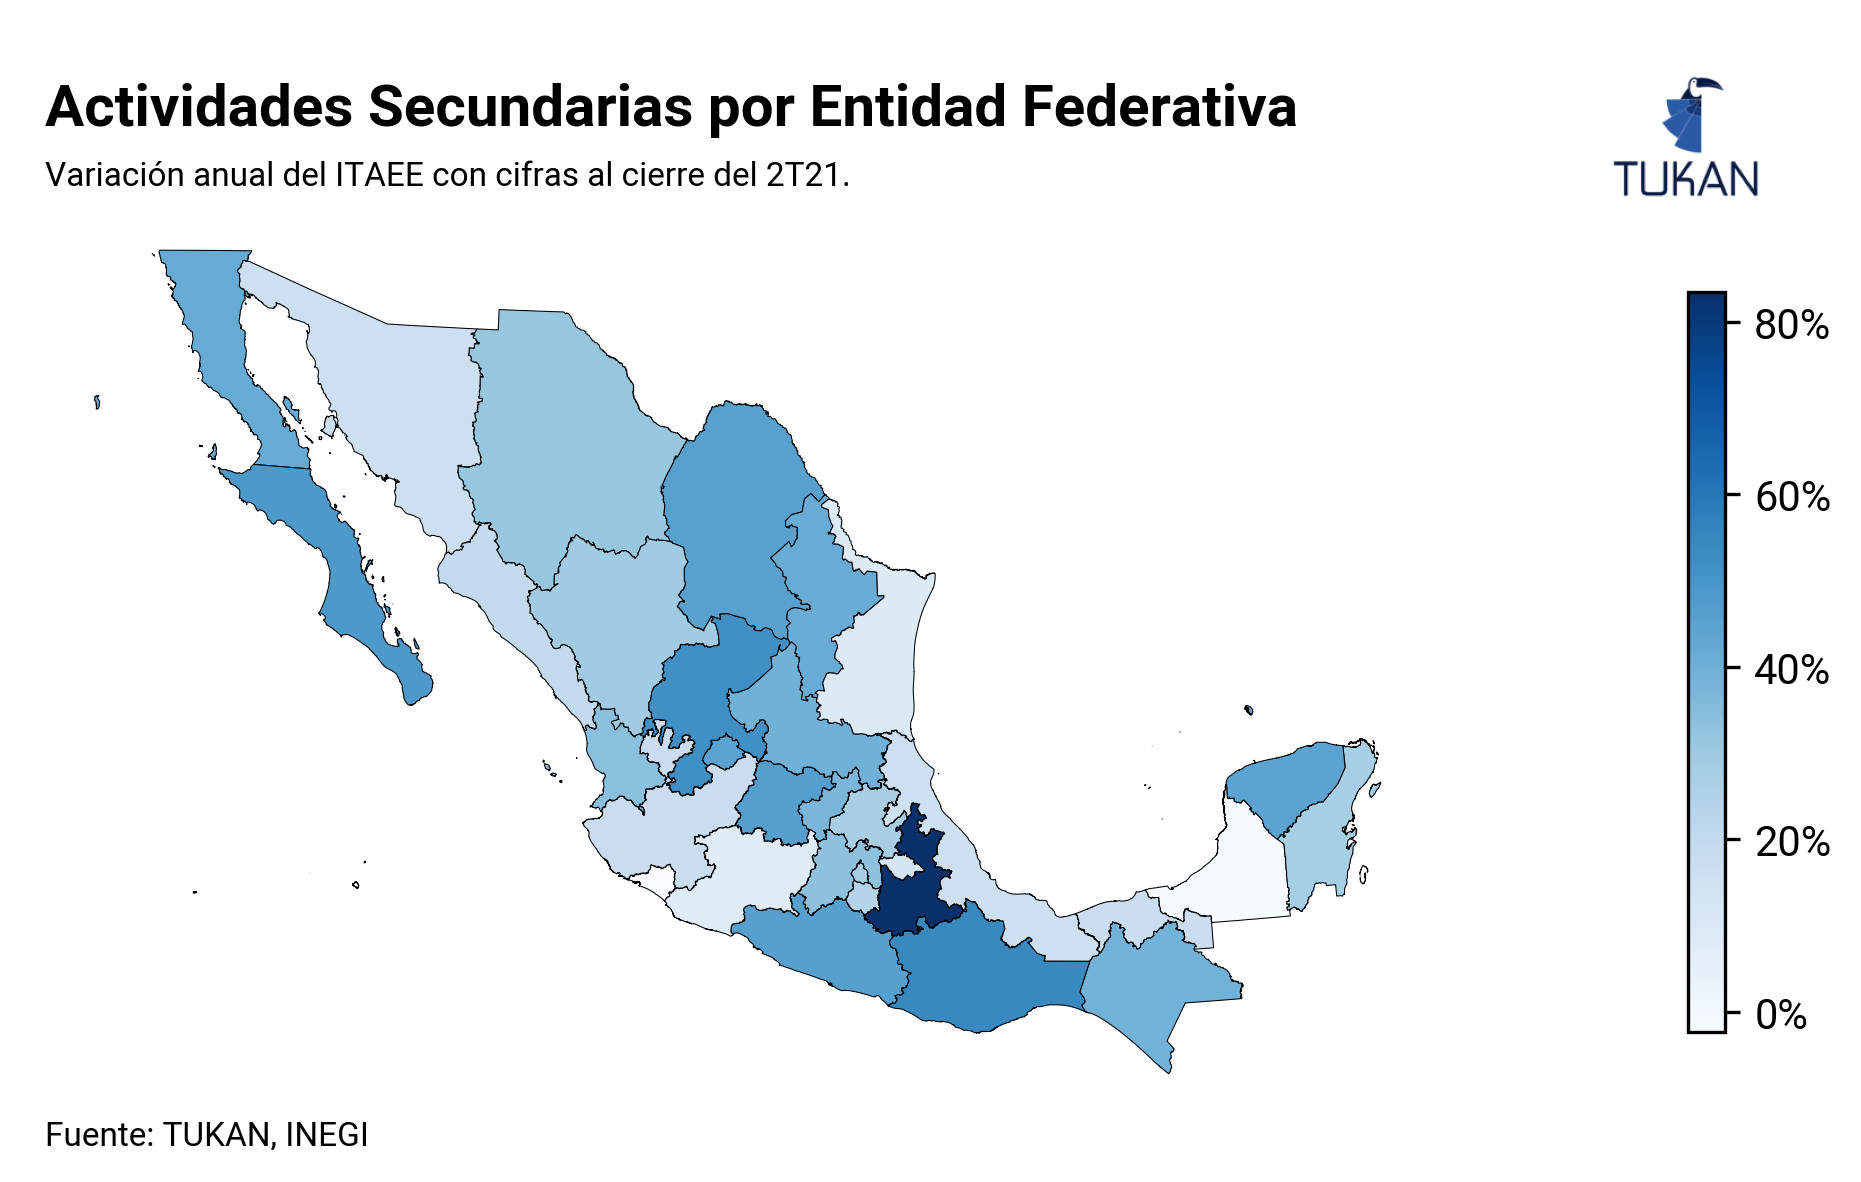

In [326]:
fig = plt.figure(figsize=(8, 4), dpi = 300)
gspec = mpl.gridspec.GridSpec(
    ncols=2, nrows=1, figure=fig, width_ratios = [.95,.05] #colorbar 05
)

ax1 = plt.subplot(gspec[0,0])
ax2 = plt.subplot(gspec[0,1])


gspec.update(wspace=-0.25, hspace=0, left = 0)
ax1.axes.set_axis_off()
ax2.axes.set_axis_off()


data.plot("92748be9624675d", ax = ax1, cmap = "Blues", linewidths = 0.25, edgecolor = "black")

# # --- Dummy heatmap colorbar
a = np.expand_dims(data['92748be9624675d'], axis=0)
heatmap=ax2.imshow(a, cmap = "Blues")
heatmap.set_visible(False)

fig.colorbar(heatmap, fraction=0.3, pad=-1, format = ticker.StrMethodFormatter('{x:.0%}'), ax = ax2)

fig.text(
    0.2,
    .95,
    "Actividades Secundarias por Entidad Federativa",
    size=14,
    weight = "bold"
)

fig.text(
    0.2,
    0.9,
    "Variación anual del ITAEE con cifras al cierre del 2T21.", #cambiar 2T21 por 3T21
    size=8
)

# Save plot with TUKAN logo, transparent and white.

fig.text(0.2, 0.1, "Fuente: TUKAN, INEGI", fontsize=8)

plt.tight_layout()


tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.78, .85, 0.15, 0.18], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/yearly_growth_secondary_map.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)

###  8 . Yearly growth for terciary activities

#### Payload

In [327]:
payload = {
    "type": "data_table",
    "operation": "yoy_growth_rel",
    "language": "es",
    "group_by": [
        "adjustment_type",
        "economic_activity",
        "geography"
    ],
    "categories": {
        "adjustment_type": "all",
        "economic_activity": [
            "8fd5b02b9f891fb"
        ],
        "geography": "all"
    },
    "request": [
        {
            "table": "mex_inegi_itaee",
            "variables": [
                "92748be9624675d"
            ]
        }
    ]
}

response = get_tukan_api_request(payload)
data = response["data"]
# data

Success getting the data


#### Filtering data

In [328]:
# data is ready to go
data['date'].unique()

array(['2021-04-01T00:00:00.000000000'], dtype='datetime64[ns]')

#### Merging data and polygons

In [329]:
data = pd.merge(df_edo, data, how = "left", on = "geography__ref").reset_index(drop = True)

data.sort_values(by="92748be9624675d", ascending = True).tail(3)

,CVEGEO,CVE_ENT,NOMGEO,geometry,geography__ref,date,economic_activity__ref,economic_activity,adjustment_type__ref,adjustment_type,geography,92748be9624675d
2,03,03,Baja California Sur,"MULTIPOLYGON (((1694656.344 1227647.637, 16946...",360a302c378e710,2021-04-01,8fd5b02b9f891fb,Actividades terciarias,a7e5d5a7d084363,Original,Baja California Sur,0.453126
11,12,12,Guerrero,"MULTIPOLYGON (((2723457.629 539108.729, 272355...",71ecab7f1483f68,2021-04-01,8fd5b02b9f891fb,Actividades terciarias,a7e5d5a7d084363,Original,Guerrero,0.675212
17,18,18,Nayarit,"MULTIPOLYGON (((2161261.691 1008297.886, 21612...",d3d2e9958774cf3,2021-04-01,8fd5b02b9f891fb,Actividades terciarias,a7e5d5a7d084363,Original,Nayarit,0.732203


#### Plot

d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
d:\TUKAN\tukan_notebooks\notebook_venv\lib\site-packages\ipykernel_launcher.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


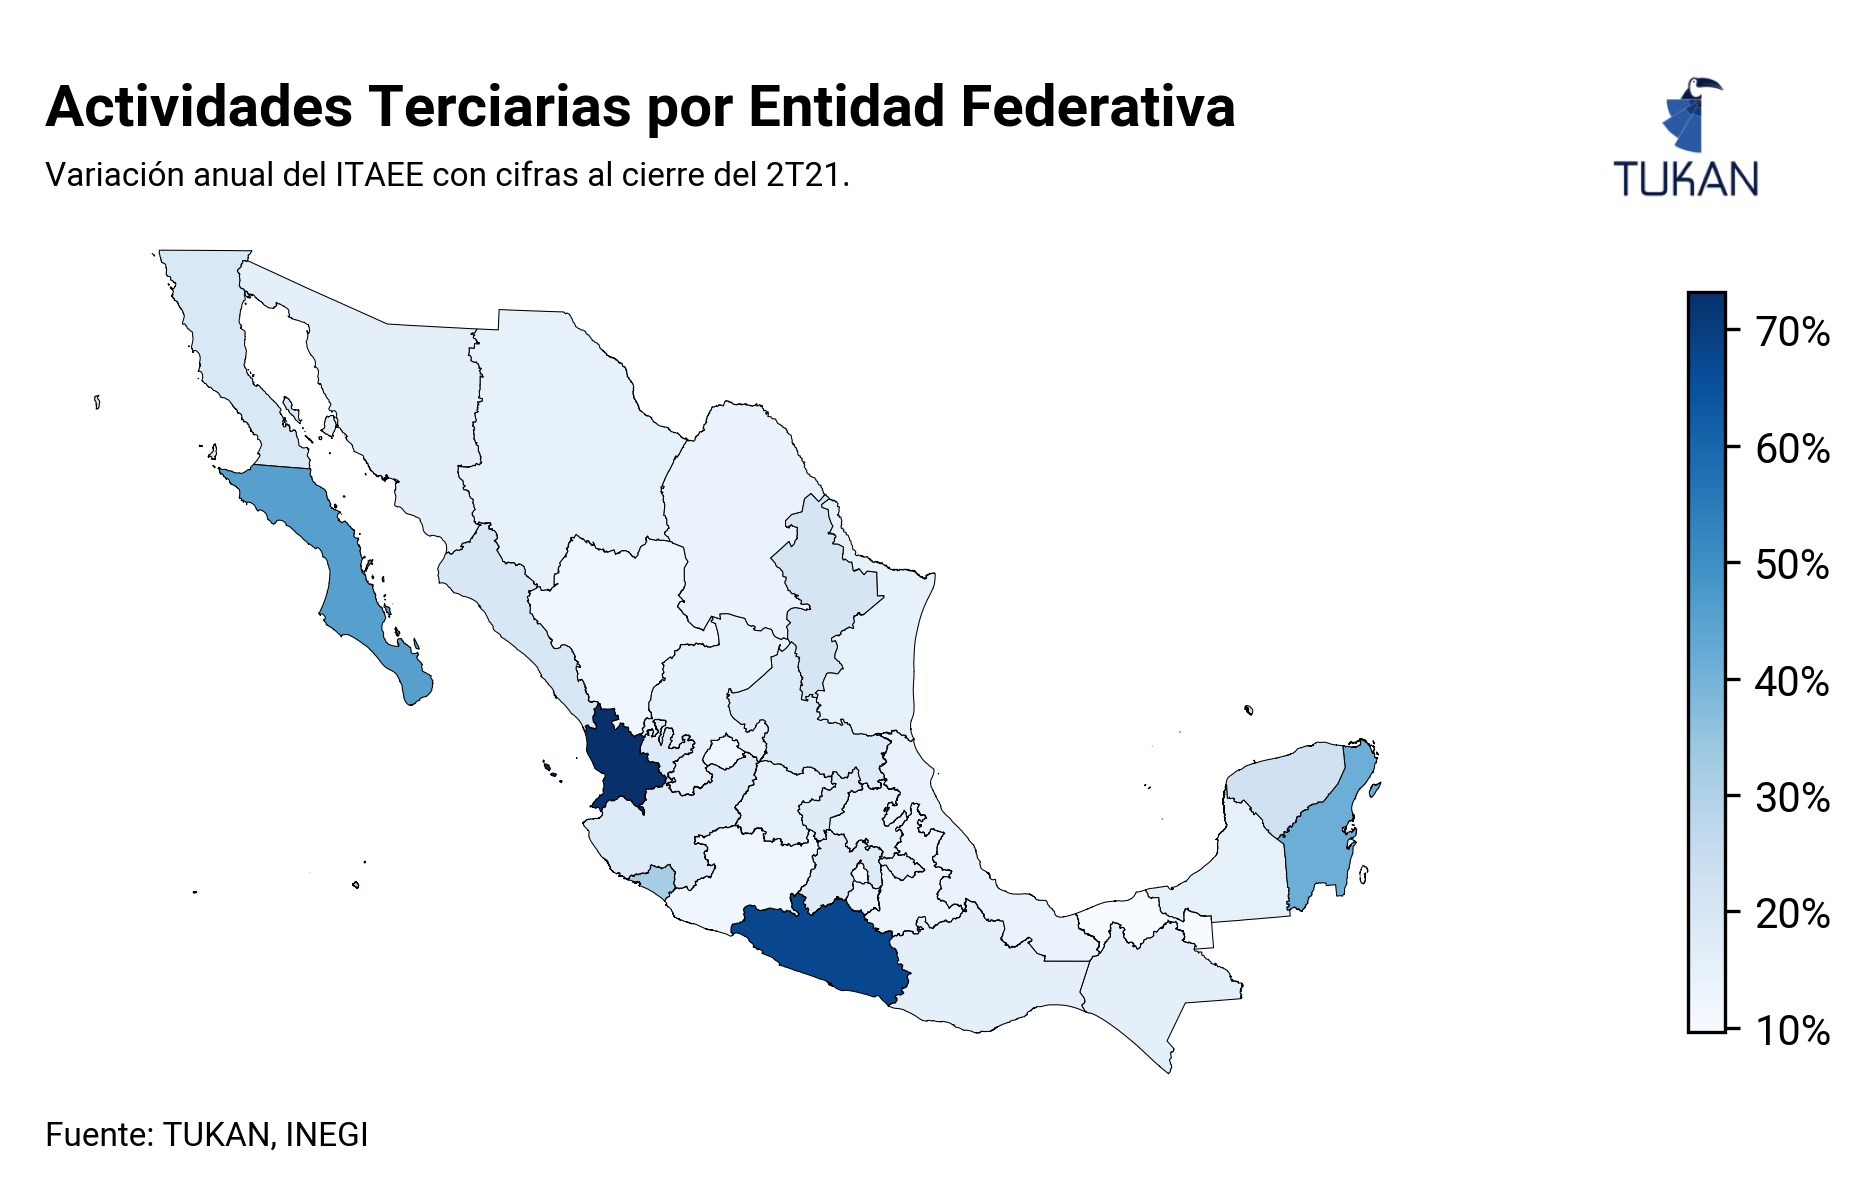

In [330]:
fig = plt.figure(figsize=(8, 4), dpi = 300)
gspec = mpl.gridspec.GridSpec(
    ncols=2, nrows=1, figure=fig, width_ratios = [.95,.05] #colorbar 05
)

ax1 = plt.subplot(gspec[0,0])
ax2 = plt.subplot(gspec[0,1])


gspec.update(wspace=-0.25, hspace=0, left = 0)
ax1.axes.set_axis_off()
ax2.axes.set_axis_off()


data.plot("92748be9624675d", ax = ax1, cmap = "Blues", linewidths = 0.25, edgecolor = "black")

# # --- Dummy heatmap colorbar
a = np.expand_dims(data['92748be9624675d'], axis=0)
heatmap=ax2.imshow(a, cmap = "Blues")
heatmap.set_visible(False)

fig.colorbar(heatmap, fraction=0.3, pad=-1, format = ticker.StrMethodFormatter('{x:.0%}'), ax = ax2)

fig.text(
    0.2,
    .95,
    "Actividades Terciarias por Entidad Federativa",
    size=14,
    weight = "bold"
)

fig.text(
    0.2,
    0.9,
    "Variación anual del ITAEE con cifras al cierre del 2T21.", #cambiar 2T21 por 3T21
    size=8
)

# Save plot with TUKAN logo, transparent and white.

fig.text(0.2, 0.1, "Fuente: TUKAN, INEGI", fontsize=8)

plt.tight_layout()


tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.78, .85, 0.15, 0.18], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/yearly_growth_terciary_map.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)